In [3]:
import yfinance as yf
import pandas as pd
import numpy as np, random, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

etf_pairs = [('VO','IWB'), 
         ('VO','SPY'), 
         ('VO','SCHX'), 
         ('VO','SPLG'), 
         ('VO', 'IVV'),
         ('VO', 'VOO'), 
         ('DVY','IWR'), 
         ('SCHV', 'SPHQ'), 
         ('IWR','DIA'), 
         ('DVY','OEF'), 
         ('VTV', 'SPHQ'), 
         ('RSP', 'DIA'), 
         ('VO', 'DIA'), 
         ('DVY', 'FVD'), 
         ('DVY','VYM')] # closing

training_data = pd.read_csv("etf_train_prices.csv", index_col = 0, parse_dates = True)
testing_data = pd.read_csv("etf_test_prices.csv", index_col = 0, parse_dates = True)

In [4]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window=z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def create_features(spread, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])

    df['z-score_lag1'] = df['z-score'].shift(1)
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag3'] = df['z-score'].shift(3)
    df['z-score_lag4'] = df['z-score'].shift(4)
    df['z-score_lag5'] = df['z-score'].shift(5)
    df['spread_lag1'] = df['spread'].shift(1)
    df['spread_lag2'] = df['spread'].shift(2)
    df['spread_lag3'] = df['spread'].shift(3)
    df['spread_lag4'] = df['spread'].shift(4)
    df['spread_lag5'] = df['spread'].shift(5)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for etf1, etf2 in etf_pairs:

    pair_name = f'{etf1}_{etf2}'

    window = 5

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, window = window)
    test_features = create_features(testing_spread, window = window)

    train_labels = predict_mean_reversion_label(
        training_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    test_labels = predict_mean_reversion_label(
        testing_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    train_idx = train_features.index.intersection(train_labels.index)
    test_idx  = test_features.index.intersection(test_labels.index)

    train_features = train_features.loc[train_idx].copy()
    test_features  = test_features.loc[test_idx].copy()

    train_labels = train_labels.loc[train_idx]
    test_labels  = test_labels.loc[test_idx]

    train_features['label'] = train_labels
    test_features['label']  = test_labels

    train_features = train_features.dropna(subset=['label'])
    test_features  = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name]  = test_features.drop(columns=['label'])
    y_test_dict[pair_name]  = test_features['label']

for pair_name in y_train_dict:
    y = y_train_dict[pair_name]
    print(pair_name, y.mean(), y.value_counts())

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

VO_IWB 0.2939189189189189 label
0.0    836
1.0    348
Name: count, dtype: int64
VO_SPY 0.29307432432432434 label
0.0    837
1.0    347
Name: count, dtype: int64
VO_SCHX 0.2947635135135135 label
0.0    835
1.0    349
Name: count, dtype: int64
VO_SPLG 0.29138513513513514 label
0.0    839
1.0    345
Name: count, dtype: int64
VO_IVV 0.2922297297297297 label
0.0    838
1.0    346
Name: count, dtype: int64
VO_VOO 0.2981418918918919 label
0.0    831
1.0    353
Name: count, dtype: int64
DVY_IWR 0.3015202702702703 label
0.0    827
1.0    357
Name: count, dtype: int64
SCHV_SPHQ 0.2829391891891892 label
0.0    849
1.0    335
Name: count, dtype: int64
IWR_DIA 0.2846283783783784 label
0.0    847
1.0    337
Name: count, dtype: int64
DVY_OEF 0.31841216216216217 label
0.0    807
1.0    377
Name: count, dtype: int64
VTV_SPHQ 0.2635135135135135 label
0.0    872
1.0    312
Name: count, dtype: int64
RSP_DIA 0.2972972972972973 label
0.0    832
1.0    352
Name: count, dtype: int64
VO_DIA 0.29138513513513514

In [5]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(max_iter = 5000,
                                               random_state = 42))])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  
    'logreg__penalty': ['l1', 'l2'],        
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__class_weight': [None, 'balanced']
}

best_params_dict = {}
best_scores_dict = {}
logreg_models = {}
test_reports = {}

cv = TimeSeriesSplit(n_splits = 5)

for pair_name in X_train_dict.keys():
    print(f"\nGrid search Logistic Regression for {pair_name}")
    
    X_train, y_train = X_train_dict[pair_name], y_train_dict[pair_name]
    X_test, y_test = X_test_dict[pair_name], y_test_dict[pair_name]
    
    grid_search = GridSearchCV(estimator = pipe, 
                               param_grid = param_grid,
                               cv = cv, 
                               scoring=  'f1_macro', 
                               n_jobs = -1, 
                               verbose = 1)
    
    grid_search.fit(X_train, y_train)
    
    best_params_dict[pair_name] = grid_search.best_params_
    best_scores_dict[pair_name] = grid_search.best_score_
    
    best_logreg = grid_search.best_estimator_
    logreg_models[pair_name] = best_logreg
    y_pred = best_logreg.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict = True)
    
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    test_reports[pair_name] = {
        'accuracy': acc,
        'report': report
    }

    print(best_params_dict[pair_name])

print("\nGrid Search Completed for All Pairs")


Grid search Logistic Regression for VO_IWB
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Test Accuracy: 0.4218
              precision    recall  f1-score   support

         0.0       0.69      0.38      0.49       861
         1.0       0.25      0.54      0.34       322

    accuracy                           0.42      1183
   macro avg       0.47      0.46      0.41      1183
weighted avg       0.57      0.42      0.45      1183

{'logreg__C': 10, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}

Grid search Logistic Regression for VO_SPY
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Test Accuracy: 0.4184
              precision    recall  f1-score   support

         0.0       0.69      0.37      0.48       860
         1.0       0.25      0.55      0.34       323

    accuracy                           0.42      1183
   macro avg       0.47      0.46      0.41      1183
weighted avg       0.57      0.42      0

In [6]:
results = {}

for pair_name in X_train_dict.keys():

    logreg_model = logreg_models[pair_name]

    X_test = X_test_dict[pair_name]
    y_test = y_test_dict[pair_name]

    y_pred = logreg_model.predict(X_test)
    probs = logreg_model.predict_proba(X_test)[:, 1]

    results[pair_name] = {
        'model': logreg_model,
        'y_true': y_test.values,
        'y_pred': probs
    }

In [7]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [8]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [9]:
def simulate_portfolio(
    X_df, y_pred_label, prices_df,
    initial_cash_per_pair=100.0,
    holding_period=5,
    entry_threshold=1,
):

    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        label = row['label']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (label == 1 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades

In [10]:
def run_simulation(results, X_test_dict, testing_data, initial_cash_per_pair=100.0):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    sns.set_theme(style = "whitegrid", context = "notebook")

    plt.figure(figsize = (12, 6))
    plt.xlabel("Date", fontsize = 12)
    plt.ylabel("Portfolio Value ($)", fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred_probs = model_info['y_pred']

        y_pred_label = (y_pred_probs >= 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(
            X_test_df,
            y_pred_label,
            prices_df,
            initial_cash_per_pair=initial_cash_per_pair
        )

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()
        sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252) if pair_returns.std() != 0 else np.nan
        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x=equity.index, y=equity.values, label=pair_name)

    plt.legend(title = "Pair", frameon = True, loc = "center left", bbox_to_anchor = (0, 0.64))
    plt.savefig("/Users/ak/Downloads/LR_equity.pdf", dpi = 400, bbox_inches = "tight")
    plt.show()

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    total_sharpe = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {total_sharpe:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))
        print("-" * 40)

    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("equity_curves/logistic_regression_equity.csv", header=["Portfolio Value"])

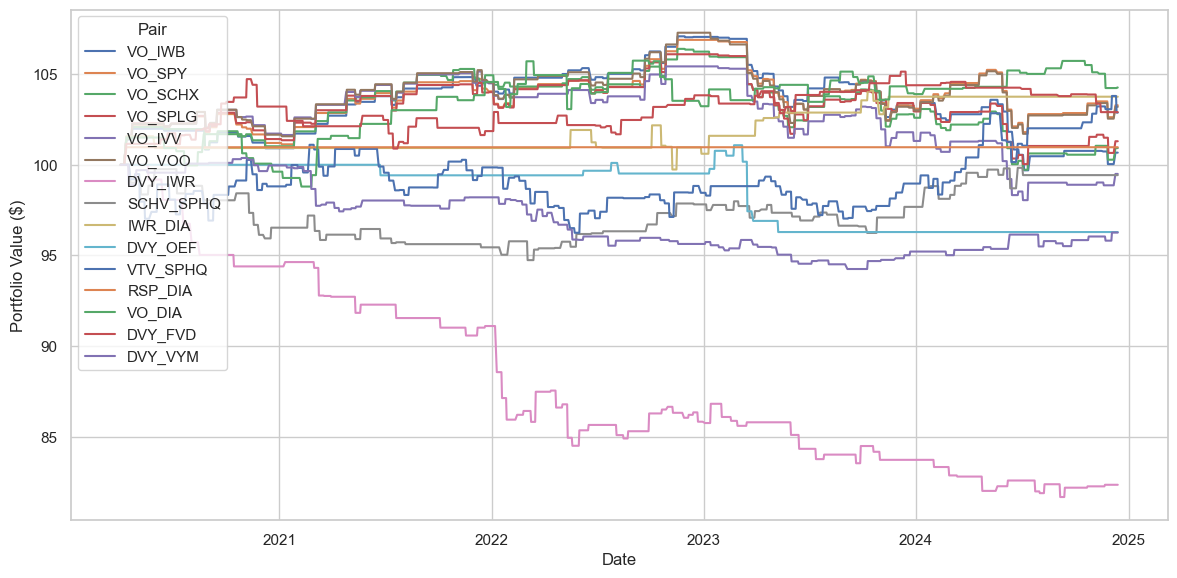


Final Portfolio Value: $1,497.96

Trade Summary:
  VO_IWB: 94 trades | Total PnL: $0.67 | Avg PnL: $0.01
  VO_SPY: 96 trades | Total PnL: $3.29 | Avg PnL: $0.03
  VO_SCHX: 97 trades | Total PnL: $0.92 | Avg PnL: $0.01
  VO_SPLG: 91 trades | Total PnL: $1.30 | Avg PnL: $0.01
  VO_IVV: 89 trades | Total PnL: $-0.51 | Avg PnL: $-0.01
  VO_VOO: 97 trades | Total PnL: $3.20 | Avg PnL: $0.03
  DVY_IWR: 70 trades | Total PnL: $-17.66 | Avg PnL: $-0.25
  SCHV_SPHQ: 76 trades | Total PnL: $-0.57 | Avg PnL: $-0.01
  IWR_DIA: 23 trades | Total PnL: $3.76 | Avg PnL: $0.16
  DVY_OEF: 12 trades | Total PnL: $-3.71 | Avg PnL: $-0.31
  VTV_SPHQ: 128 trades | Total PnL: $2.88 | Avg PnL: $0.02
  RSP_DIA: 1 trades | Total PnL: $0.97 | Avg PnL: $0.97
  VO_DIA: 76 trades | Total PnL: $4.26 | Avg PnL: $0.06
  DVY_FVD: 71 trades | Total PnL: $2.90 | Avg PnL: $0.04
  DVY_VYM: 90 trades | Total PnL: $-3.74 | Avg PnL: $-0.04

Year-End Portfolio Values:
                VO_IWB      VO_SPY     VO_SCHX     VO_SPLG

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_13686/1430349399.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


In [11]:
run_simulation(results, X_test_dict, testing_data)